# *Image Captioning*

## Import Dependencies

In [1]:
import os
import re
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
from matplotlib import pyplot as plt

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import add, Dense, Dropout, Embedding, Input, LSTM

2024-08-02 16:39:11.526407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:39:11.526462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:39:11.527904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Values

In [2]:
DATASET_DIR = '/kaggle/input/captioning-dataset-200k/images_200k'
SAVE_DIR = '/kaggle/working/'

In [3]:
info_df = pd.read_csv('/kaggle/input/captioning-dataset-200k/image_info.csv')
info_df.head()

,image_id,caption
0,3135d76d4d98602d,In this image we can see a child is sliding on...
1,85c6590a9ed64e21,In this image I can see vehicles on the road. ...
2,444df32b07ad1713,In this picture I can observe a man and woman ...
3,fdeecd0c588b3fd8,In this image there is a person standing on th...
4,e0c36befc819c1ea,"In this image we can see people, light and in ..."


In [4]:
img_names = os.listdir(DATASET_DIR)

## Feature Extraction of Images

In [5]:
model = VGG16(weights='imagenet')
vgg16_feature_extractor = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
vgg16_feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
img_features_1 = {}
captions_1 = {}
img_features_2 = {}
captions_2 = {}

In [7]:
half_index = len(info_df) // 2
info_df_first_half = info_df.iloc[:half_index]
info_df_second_half = info_df.iloc[half_index:]

In [8]:
def process_image(img_id, caption, img_names, dataset_dir, feature_extractor):
    img_name = f'{img_id}.jpg'
    if img_name in img_names:
        img_path = os.path.join(dataset_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        
        img_feature = feature_extractor.predict(img, verbose=0)
        return img_id, img_feature, caption
    else:
        return img_id, None, None

In [9]:
def process_images(df, img_names, dataset_dir, feature_extractor, desc):
    img_features = {}
    captions = {}
    total = len(df)
    
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(process_image, img_id, caption, img_names, dataset_dir, feature_extractor): (img_id, caption)
                   for img_id, caption in df.itertuples(index=False)}
        
        with tqdm(total=total, desc=desc, unit='image') as pbar:
            for future in as_completed(futures):
                try:
                    img_id, img_feature, caption = future.result()
                    if img_feature is not None:
                        img_features[img_id] = img_feature
                        captions[img_id] = caption
                except Exception as e:
                    print(f"Error processing image {futures[future][0]}: {e}")
                
                pbar.update(1)
    
    return img_features, captions

In [10]:
img_features_1, captions_1 = process_images(info_df_first_half, img_names, DATASET_DIR, vgg16_feature_extractor, "Processing first half")

with open('img_features_1.pkl', 'wb') as f:
    pickle.dump(img_features_1, f)
with open('captions_1.pkl', 'wb') as f:
    pickle.dump(captions_1, f)


Processing first half: 100%|██████████| 100000/100000 [1:18:52<00:00, 21.13image/s]


In [11]:
img_features_2, captions_2 = process_images(info_df_second_half, img_names, DATASET_DIR, vgg16_feature_extractor, "Processing second half")

with open('img_features_2.pkl', 'wb') as f:
    pickle.dump(img_features_2, f)
    
with open('captions_2.pkl', 'wb') as f:
    pickle.dump(captions_2, f)

Processing second half: 100%|██████████| 100000/100000 [1:19:24<00:00, 20.99image/s]


In [12]:
with open("img_features_1.pkl", "rb") as file:
    img_features_1 = pickle.load(file)
    
with open("captions_1.pkl", "rb") as file:
    captions_1 = pickle.load(file)

with open("img_features_2.pkl", "rb") as file:
    img_features_2 = pickle.load(file)
    
with open("captions_2.pkl", "rb") as file:
    captions_2 = pickle.load(file)

In [13]:
img_features = {**img_features_1, **img_features_2}
captions = {**captions_1, **captions_2}

In [14]:
len(img_features), len(captions)

(200000, 200000)

## Preprocessing Text

In [15]:
def preprocess_text(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = " ".join([word for word in caption.split() if len(word) > 1])
    caption = f"startseq {caption} endseq"
    return caption

def preprocess_captions(captions_):
    preprocessed_captions = {}
    for img_id, caption in tqdm(captions_.items()):
        preprocessed_captions[img_id] = preprocess_text(caption)
    return preprocessed_captions

In [16]:
# before preprocessing
captions[list(captions.keys())[0]]

'In this image we can see a person keeping goggles on the head. On the ground there is grass. In the back there are trees. Also there is sky.'

In [17]:
captions = preprocess_captions(captions)

100%|██████████| 200000/200000 [00:06<00:00, 28989.14it/s]


In [18]:
# after preprocessing
captions[list(captions.keys())[0]]

'startseq in this image we can see person keeping goggles on the head on the ground there is grass in the back there are trees also there is sky endseq'

In [19]:
all_captions = []
for caption in captions.values():
    all_captions.append(caption)

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
num_words = vocab_size
vocab_size

15817

In [22]:
time_steps = max(len(caption.split()) for caption in all_captions)
time_steps

237

## Train-Val-Test Split

In [23]:
img_ids = list(captions.keys())

In [24]:
train_split = int(len(img_ids) * 0.75)
val_split = int(len(img_ids) * 0.2)
test_split = len(img_ids) - train_split - val_split

In [25]:
train_img_ids = img_ids[:train_split]
val_img_ids = img_ids[train_split:train_split+val_split]
test_img_ids = img_ids[train_split+val_split:]

In [26]:
def get_img_and_seqs(id_type):
    images = []
    sequences = []
    
    for img_id in id_type:
        images.append(img_features[img_id])
        sequences.append(captions[img_id])
    return images, sequences

In [27]:
train_images, train_sequences = get_img_and_seqs(train_img_ids)
val_images, val_sequences = get_img_and_seqs(val_img_ids)
test_images, test_sequences = get_img_and_seqs(test_img_ids)

## Generator Creation

In [28]:
def data_generator(images, captions, tokenizer, time_steps, vocab_size, batch_size):
    img_input, caption_input, caption_output = [], [], []
    
    while True:
        for image, caption in zip(images, captions):
            caption = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(caption)):
                in_seq, out_seq = caption[:i], caption[i]
                in_seq = pad_sequences([in_seq], padding='post', maxlen=time_steps)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                
                img_input.append(image[0])
                caption_input.append(in_seq)
                caption_output.append(out_seq)
                                
                if len(img_input) == batch_size:
                    yield (np.array(img_input), np.array(caption_input)), np.array(caption_output)
                    img_input, caption_input, caption_output = [], [], []
                
        if img_input:
            yield (np.array(img_input), np.array(caption_input)), np.array(caption_output)
            img_input, caption_input, caption_output = [], [], []

## Model Creation

In [29]:
img_input = Input(shape=(4096,))
img_l1 = Dropout(0.5)(img_input)
img_l2 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(img_l1)

text_input = Input(shape=(time_steps,))
text_l1 = Embedding(num_words, 512, mask_zero=True)(text_input)
text_l2 = Dropout(0.5)(text_l1)
text_l3 = LSTM(256, return_sequences=False)(text_l2)

decoder_1 = add([img_l2, text_l3])
decoder_2 = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(decoder_1)
outputs = Dense(num_words, activation="softmax")(decoder_2)

model = Model(inputs=[img_input, text_input], outputs=outputs)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

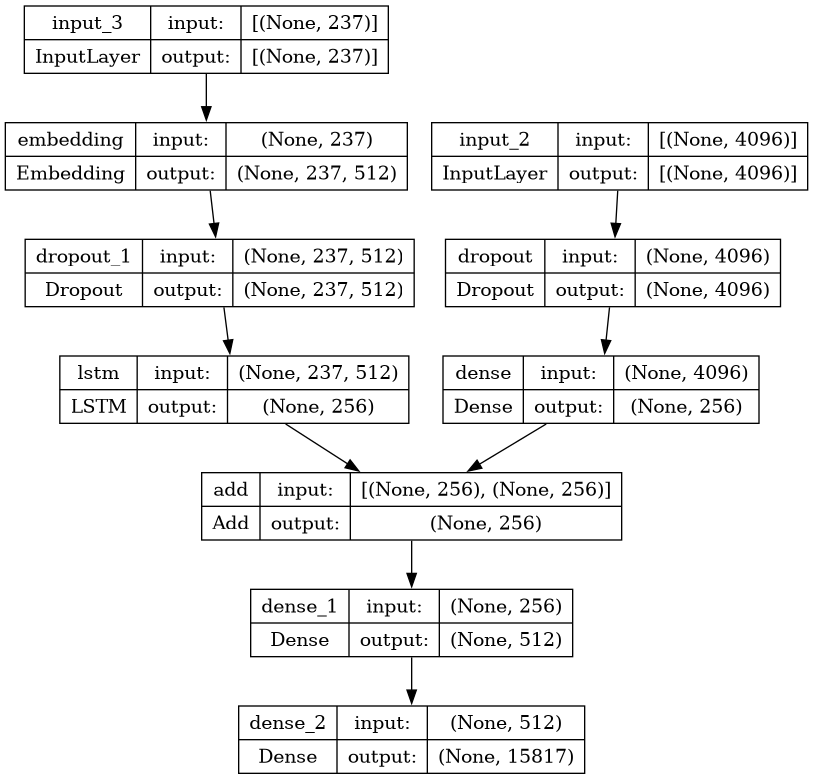

In [30]:
plot_model(model, show_shapes=True)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 237)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 237, 512)             8098304   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [33]:
batch_size = 64

output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32), tf.TensorSpec(shape=(None, time_steps), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, num_words), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_images, train_sequences, tokenizer, time_steps, num_words, batch_size),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_images, val_sequences, tokenizer, time_steps, num_words, batch_size),
    output_signature=output_signature
)

In [34]:
train_steps = len(train_img_ids) // batch_size
val_steps = len(val_img_ids) // batch_size

history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5


I0000 00:00:1722616783.686035    2073 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2343/2343 [==============================] - 81s 32ms/step - loss: 3.7279 - accuracy: 0.3514 - val_loss: 2.9993 - val_accuracy: 0.4175 - lr: 0.0010
Epoch 2/5
2343/2343 [==============================] - 69s 29ms/step - loss: 2.8870 - accuracy: 0.4240 - val_loss: 2.7825 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 3/5
2343/2343 [==============================] - 69s 29ms/step - loss: 2.7641 - accuracy: 0.4387 - val_loss: 2.6961 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 4/5
2343/2343 [==============================] - 68s 29ms/step - loss: 2.6891 - accuracy: 0.4495 - val_loss: 2.6229 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 5/5
2343/2343 [==============================] - 69s 29ms/step - loss: 2.6508 - accuracy: 0.4568 - val_loss: 2.5861 - val_accuracy: 0.4646 - lr: 0.0010


## Save Models and Tokenizer

In [35]:
vgg16_feature_extractor.save("feature_extractor_200k.h5")
model.save("image_captioner_200k.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer_100k.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

## Load Model

In [37]:
caption_generator = load_model("image_captioner_200k.h5")
vgg16_feature_extractor = load_model("feature_extractor_200k.h5")

## Generate Captions for test Images

In [38]:
def index_to_word(num, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == num:
            return word
    return None

In [39]:
def display_image(img_path):
    img = Image.open(img_path).resize((300, 300)).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [40]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    img = vgg16_feature_extractor.predict(img, verbose=0)
    
    return img

In [41]:
def predict_caption(img_features, tokenizer, time_steps, img_path):
    
    in_text = "startseq"
    img = preprocess_image(img_path)
    display_image(img_path)
            
    for i in range(time_steps):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([seq], padding='post', maxlen=time_steps)
        
        yhat = caption_generator.predict([img, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = index_to_word(yhat, tokenizer)
        
        if word is None:
            break
            
        in_text += f' {word}'
        
        if word == "endseq":
            break
            
    return " ".join(in_text.split()[1:-1])

Actual : startseq it is closed room where so many people sitting on the chairs and in front of the table there are water bottles glasses plates spoons tissues and at the right corner of the picture there are balloons tied to the table and behind them there is big wall where ac light and two wooden boxes attached to it where at the left corner of the picture door is present endseq


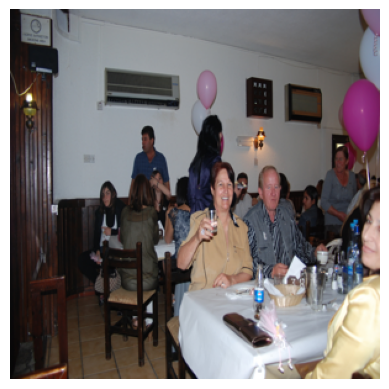

Predicted : in this image we can see some people are sitting on the chairs and holding some objects in the background we can see the wall and some objects


In [42]:
img_id = test_img_ids[50]
img_path = os.path.join(DATASET_DIR, f'{img_id}.jpg')
actual_caption = captions[img_id]

print(f"Actual : {actual_caption}")

y_pred = predict_caption(img_features, tokenizer, time_steps, img_path)
print(f"Predicted : {y_pred}")

Actual : startseq in this image there are few people we can see the wall and some cardboard boxes we can see some watermark on the top left corner endseq


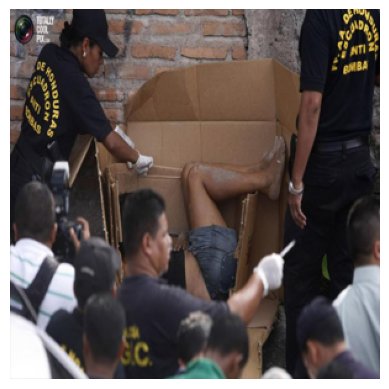

Predicted : in this image we can see man standing and holding guitar in the background we can see the wall


In [43]:
img_id = test_img_ids[500]
img_path = os.path.join(DATASET_DIR, f'{img_id}.jpg')
actual_caption = captions[img_id]

print(f"Actual : {actual_caption}")

y_pred = predict_caption(img_features, tokenizer, time_steps, img_path)
print(f"Predicted : {y_pred}")

Actual : startseq in the center of the image we can see mountain with painting on it there are trees at the bottom of the image there is grass at the top of the image there is sky endseq


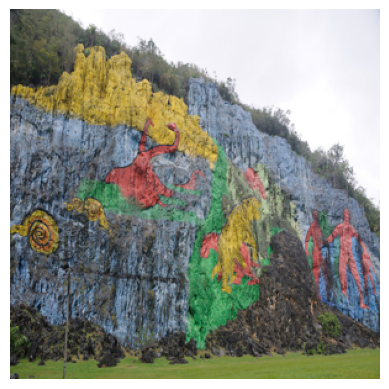

Predicted : in this image we can see the trees and the sky in the background we can see the sky


In [44]:
img_id = test_img_ids[1500]
img_path = os.path.join(DATASET_DIR, f'{img_id}.jpg')
actual_caption = captions[img_id]

print(f"Actual : {actual_caption}")

y_pred = predict_caption(img_features, tokenizer, time_steps, img_path)
print(f"Predicted : {y_pred}")

Actual : startseq women with short golden hair wearing pink shirt is speaking to people surrounded by her this is table and the papers are around this is teacup there are seven people sitting around table back of this men there is glass window which is made up of glass endseq


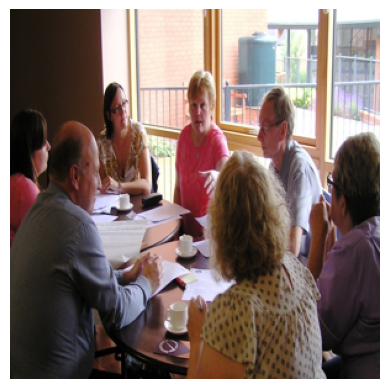

Predicted : in this image we can see some people are sitting on the chairs and holding some objects in the background we can see the wall and the wall


In [45]:
img_id = test_img_ids[3000]
img_path = os.path.join(DATASET_DIR, f'{img_id}.jpg')
actual_caption = captions[img_id]

print(f"Actual : {actual_caption}")

y_pred = predict_caption(img_features, tokenizer, time_steps, img_path)
print(f"Predicted : {y_pred}")

Actual : startseq in this image at front there is car on the road at the back side theres grass on the surface at the background there are trees buildings and sky endseq


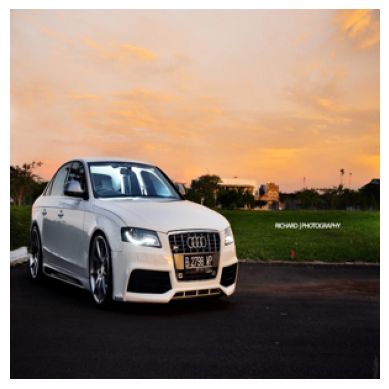

Predicted : in this image we can see the road on the left side of the image we can see the road and we can see the buildings and some trees in the background we can see the sky


In [46]:
img_id = test_img_ids[6000]
img_path = os.path.join(DATASET_DIR, f'{img_id}.jpg')
actual_caption = captions[img_id]

print(f"Actual : {actual_caption}")

y_pred = predict_caption(img_features, tokenizer, time_steps, img_path)
print(f"Predicted : {y_pred}")